## Choosing top 10 Important features positively effecting DPPH Scavenging Activity

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.inspection import permutation_importance
import xgboost as xgb

# 1. Load data
df = pd.read_excel("14 media DPPH Scavanging test.xlsx")

# Drop "Media name" column if exists
if "Media Name" in df.columns:
    df = df.drop(columns=["Media Name"])

# Assuming the last column is the target (DPPH activity)
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

# Filter features with positive correlation to target
positive_features = X.columns[X.corrwith(y) > 0]
X = X[positive_features]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

def evaluate_model(model, X_train, y_train, X_test, y_test):
    """Train, predict, and evaluate a regression model."""
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    return r2, mae, rmse, model

def get_feature_importance(model, model_name):
    """Extract feature importance depending on model type, keeping only positive contributors."""
    if model_name in ["RandomForest", "XGBoost"]:
        importance = model.feature_importances_
        importance_series = pd.Series(importance, index=X.columns)
        # Keep only features that had positive correlation
        importance_series = importance_series.loc[positive_features]
    elif model_name == "Lasso":
        # Use raw coefficients, keep only positive ones
        coef_series = pd.Series(model.coef_, index=X.columns)
        importance_series = coef_series[coef_series > 0]
    elif model_name == "MLP":
        result = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)
        importance = result.importances_mean
        importance_series = pd.Series(importance, index=X.columns)
        # Keep only features with positive correlation
        importance_series = importance_series.loc[positive_features]
    else:
        raise ValueError("Unknown model type")
    
    return importance_series.sort_values(ascending=False)

# Models
models = {
    "RandomForest": RandomForestRegressor(n_estimators=200, random_state=42),
    "XGBoost": xgb.XGBRegressor(n_estimators=200, learning_rate=0.05, random_state=42),
    "Lasso": Lasso(alpha=0.001, max_iter=10000, random_state=42),
    "MLP": MLPRegressor(hidden_layer_sizes=(64,32), max_iter=500, random_state=42)
}

results = {}
feature_rankings = {}

for name, model in models.items():
    print(f"\nRunning {name}...")
    r2, mae, rmse, fitted_model = evaluate_model(model, X_train, y_train, X_test, y_test)
    print(f"{name} Performance:")
    print(f"  R²   : {r2:.4f}")
    print(f"  MAE  : {mae:.4f}")
    print(f"  RMSE : {rmse:.4f}")
    
    results[name] = {"R2": r2, "MAE": mae, "RMSE": rmse}
    
    importance_series = get_feature_importance(fitted_model, name)
    feature_rankings[name] = importance_series
    print(f"\nTop 10 positively contributing ingredients ({name}):")
    print(importance_series.head(10))


Running RandomForest...
RandomForest Performance:
  R²   : 0.8239
  MAE  : 10.1544
  RMSE : 13.0672

Top 10 positively contributing ingredients (RandomForest):
K₂HPO₄                            0.411799
Yeast extract                     0.218306
 Peptone                          0.122350
Temperature                       0.079808
PH                                0.062365
Glucose                           0.045520
Beef Extract                      0.018938
NaCl                              0.018377
Tryptone (or Trypticase) (g/L)    0.006157
Dextrose                          0.004277
dtype: float64

Running XGBoost...
XGBoost Performance:
  R²   : 0.8928
  MAE  : 6.6053
  RMSE : 10.1947

Top 10 positively contributing ingredients (XGBoost):
Temperature                       0.486462
K₂HPO₄                            0.418264
Glucose                           0.041461
Tryptone (or Trypticase) (g/L)    0.028684
Yeast extract                     0.012808
 Peptone                          

C:\Users\soura\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.078e+01, tolerance: 3.550e+00
  model = cd_fast.enet_coordinate_descent(
C:\Users\soura\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:780: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


MLP Performance:
  R²   : 0.5755
  MAE  : 14.4679
  RMSE : 20.2902

Top 10 positively contributing ingredients (MLP):
 Peptone                          1.276280
Yeast extract                     0.553378
Tryptone (or Trypticase) (g/L)    0.518510
Sodium lactate                    0.293192
Beef Extract                      0.268229
NaCl                              0.258905
Soytone                           0.156216
Streptomycin                      0.090470
Dextrose                          0.072389
Pancreatic digest of gelatin      0.071219
dtype: float64


C:\Users\soura\AppData\Local\Temp\ipykernel_23464\939735120.py:66: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feat_df, x="Importance", y="Feature", ax=axes[1], palette="viridis")


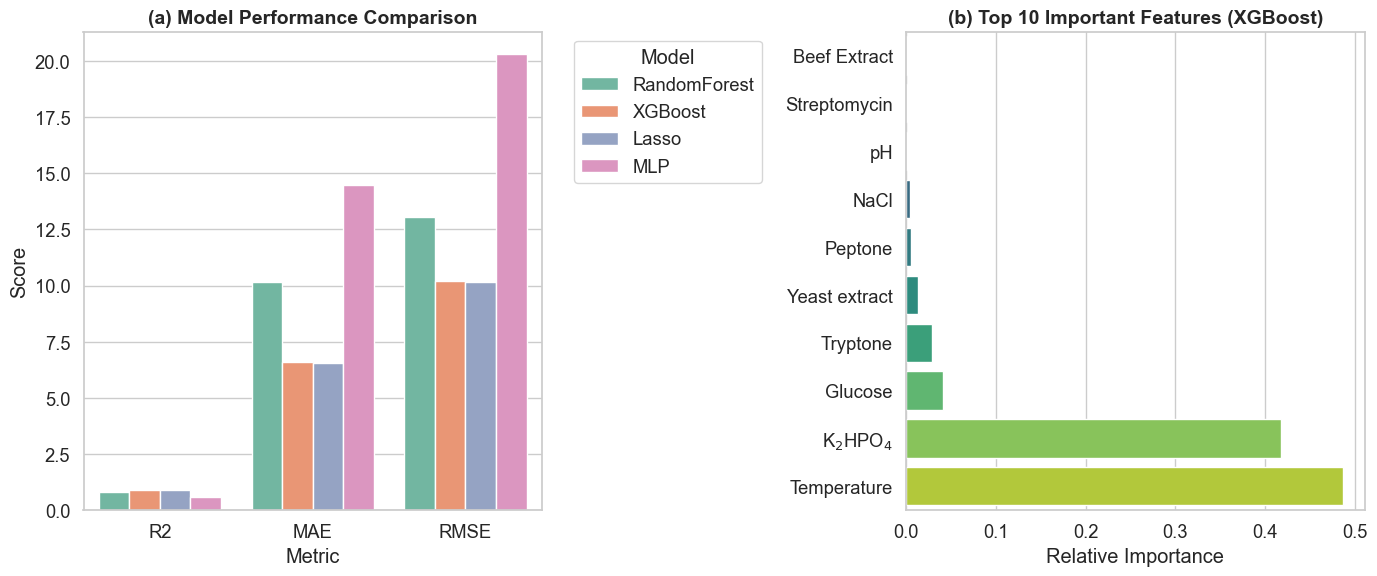

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# --------------------------
# Example Results (replace with your actual results dict & feature importance)
# --------------------------
results = {
    "RandomForest": {"R2": 0.8239, "MAE": 10.1544, "RMSE": 13.0672},
    "XGBoost": {"R2": 0.8928, "MAE": 6.6053, "RMSE": 10.1947},
    "Lasso": {"R2": 0.8939, "MAE": 6.5711, "RMSE": 10.1429},
    "MLP": {"R2": 0.5755, "MAE": 14.4679, "RMSE": 20.2902}
}

# Update feature importance: Remove Dextrose and replace with NaCl
xgb_features = {
    "Temperature": 0.486462,
    "K₂HPO₄": 0.418264,
    "Glucose": 0.041461,
    "Tryptone": 0.028684,
    "Yeast extract": 0.012808,
    "Peptone": 0.004923,
    "NaCl": 0.004785,  # Replaced Dextrose with NaCl
    "pH": 0.001223,
    "Streptomycin": 0.000731,
    "Beef Extract": 0.000431
}

# Convert performance results to DataFrame
perf_df = pd.DataFrame(results).T.reset_index().rename(columns={"index": "Model"})

# Convert feature importance to DataFrame
feat_df = pd.DataFrame(list(xgb_features.items()), columns=["Feature", "Importance"])
feat_df = feat_df.sort_values("Importance", ascending=True)

# --------------------------
# Plot
# --------------------------
sns.set(style="whitegrid", font_scale=1.2)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# --- Panel A: Model Performance ---
metrics = ["R2", "MAE", "RMSE"]
perf_melt = perf_df.melt(id_vars="Model", value_vars=metrics,
                         var_name="Metric", value_name="Score")

sns.barplot(data=perf_melt, x="Metric", y="Score", hue="Model", ax=axes[0], palette="Set2")
axes[0].set_title("(a) Model Performance Comparison", fontsize=14, weight="bold")
axes[0].legend(title="Model", bbox_to_anchor=(1.05, 1), loc="upper left")

# --- Panel B: XGBoost Feature Importance ---
# For LaTeX rendering of chemical formulas
feat_df['Feature'] = feat_df['Feature'].replace({
    'K₂HPO₄': r'K$_2$HPO$_4$',
    'Tryptone': 'Tryptone',
    'Yeast extract': 'Yeast extract',
    'Peptone': 'Peptone',
    'NaCl': r'NaCl',  # Correcting NaCl representation
    'Beef Extract': 'Beef Extract',
    'Glucose': 'Glucose',
    'pH': 'pH',
    'Streptomycin': 'Streptomycin'
})

sns.barplot(data=feat_df, x="Importance", y="Feature", ax=axes[1], palette="viridis")
axes[1].set_title("(b) Top 10 Important Features (XGBoost)", fontsize=14, weight="bold")
axes[1].set_xlabel("Relative Importance")
axes[1].set_ylabel("")

# Tight layout
plt.tight_layout()

# Save as high-res for journal submission
plt.savefig("Figure2.tif", dpi=600, format="tiff")  # high-quality for journal
plt.savefig("Figure2.png", dpi=300, format="png")  # preview version

# Display the figure (if needed)
plt.show()


<b><b><b><b><b><b><b><b><b>